# Prescriptive Analytics

### Customer Segmentation & Strategic Recommendations

**Goal:** To provide actionable recommendations to improve customer satisfaction & retention

**Key Insights from Previous Notebooks:**
- 97% are one-time customers (retention issue) - [Descriptive Analytics](03_descriptive_analytics.ipynb)
- Delivery delays are primary satisfaction drivers (r = 0.37) - [Diagnostic Analytics](04_diagnostic_analytics.ipynb)
- Geographic distance impacts delivery performance - [Diagnostic Analytics](04_diagnostic_analytics.ipynb)
- Predictive model can identify 41% of poor reviews proactively (Random Forest) - [Predictive Analytics](05_predictive_modeling.ipynb)
- Category Urgency delay sensitivity - [Diagnostic Analytics](04_diagnostic_analytics.ipynb)

In [1]:
# Imports, Settings, and db connection 

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

conn = sqlite3.connect('../data/ecommerce.db')
print('Connected to database')

Connected to database


### 1. RFM (Recent, Frequency, Monetary) Analysis - Customer Segmentation

#### 1.1 RFM Metrics

In [2]:
# RFM analysis 
rfm_query = """
WITH customer_summary AS (
    SELECT 
        c.customer_unique_id,
        c.customer_state,
        COUNT(DISTINCT o.order_id) as frequency,
        SUM(oi.price + oi.freight_value) as monetary,
        MAX(o.order_purchase_timestamp) as last_purchase_date,
        AVG(r.review_score) as avg_review,
        AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date)) as avg_delay
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
)
SELECT 
    *,
    JULIANDAY('2018-10-17') - JULIANDAY(last_purchase_date) as recency_days
FROM customer_summary
"""

rfm = pd.read_sql(rfm_query, conn)

print(f"Total customers: {len(rfm):,}")
print(f"\nRFM Summary:")
print(rfm[['recency_days', 'frequency', 'monetary']].describe())
rfm.head()

Total customers: 93,358

RFM Summary:
       recency_days     frequency      monetary
count  93358.000000  93358.000000  93358.000000
mean     285.841944      1.033420    165.916853
std      152.593265      0.209097    227.787005
min       48.374572      1.000000      9.590000
25%      162.275987      1.000000     63.100000
50%      266.991522      1.000000    107.890000
75%      394.232465      1.000000    183.120000
max      761.488449     15.000000  13664.080000


,customer_unique_id,customer_state,frequency,monetary,last_purchase_date,avg_review,avg_delay,recency_days
0,0000366f3b9a7992bf8c76cfdf3221e2,SP,1,141.90,2018-05-10 10:56:27,5.0,-4.132905,159.544132
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP,1,27.19,2018-05-07 11:11:27,4.0,-4.248125,162.533715
2,0000f46a3911fa3c0805444483337064,SC,1,86.22,2017-03-10 21:05:03,3.0,-1.389734,585.121493
3,0000f6ccb0745a6a4b88665a16c9f078,PA,1,43.62,2017-10-12 20:29:41,4.0,-11.108970,369.146053
4,0004aac84e0df4da2b147fca70cf8255,SP,1,196.89,2017-11-14 19:45:42,5.0,-7.035463,336.176597


#### 1.2 Create RFM Scores

In [3]:
# Scoring each metric (ratings 1-5 and 5 is best)
rfm['R_score'] = pd.qcut(rfm['recency_days'], q=5, labels=[5,4,3,2,1])  # Lower recency = better
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['monetary'].rank(method='first'), q=5, labels=[1,2,3,4,5])

# Converting the metrics to numeric
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

# Calculating combined RFM score
rfm['RFM_score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

print("RFM Score Distribution:")
print(rfm['RFM_score'].describe())
rfm[['customer_unique_id', 'recency_days', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']].head(10)

RFM Score Distribution:
count    93358.000000
mean         9.000000
std          2.498917
min          3.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         15.000000
Name: RFM_score, dtype: float64


,customer_unique_id,recency_days,frequency,monetary,R_score,F_score,M_score,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,159.544132,1,141.90,4,1,4,9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162.533715,1,27.19,4,1,1,6
2,0000f46a3911fa3c0805444483337064,585.121493,1,86.22,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,369.146053,1,43.62,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,336.176597,1,196.89,2,1,4,7
5,0004bd2a26a76fe21f786e4fbd80607f,194.185231,1,166.98,4,1,4,9
6,00050ab1314c0e55a6ca13cf7181fecf,179.460150,1,35.38,4,1,1,6
7,00053a61a98854899e70ed204dd4bafe,230.530775,1,419.18,3,1,5,9
8,0005e1862207bf6ccc02e4228effd9a0,591.019306,1,150.12,1,1,4,6
9,0005ef4cd20d2893f0d9fbd94d3c0d97,218.359583,1,129.76,4,1,3,8


#### 1.3 Customer Segmentation

In [4]:
# Function to segment customers based on RFM score

def segment_customer(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    # Champions: Best customers (recent, frequent, high spend)
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    # Loyal: Frequent buyers regardless of recency
    elif f >= 4:
        return 'Loyal Customers'
    
    # Potential Loyalists: Recent customers with potential
    elif r >= 4 and f >= 2:
        return 'Potential Loyalists'
    
    # At Risk: Good customers who haven't purchased recently
    elif f >= 3 and r <= 2:
        return 'At Risk'
    
    # Recent Customers: Just made first purchase
    elif r >= 4 and f == 1:
        return 'New Customers'
    
    # Promising: Decent score but need nurturing
    elif r >= 3 and m >= 3:
        return 'Promising'
    
    # Need Attention: Low engagement
    elif r <= 2 and f <= 2:
        return 'Need Attention'
    
    # Lost: Haven't purchased in long time
    else:
        return 'Lost'

rfm['segment'] = rfm.apply(segment_customer, axis=1)

print("Customer Segments:")
segment_summary = rfm['segment'].value_counts()
print(segment_summary)
print(f"\nPercentages:")
print((segment_summary / len(rfm) * 100).round(2))

Customer Segments:
segment
Loyal Customers        30885
Need Attention         15033
Potential Loyalists    14965
New Customers           7461
At Risk                 7457
Promising               6521
Champions               6458
Lost                    4578
Name: count, dtype: int64

Percentages:
segment
Loyal Customers        33.08
Need Attention         16.10
Potential Loyalists    16.03
New Customers           7.99
At Risk                 7.99
Promising               6.98
Champions               6.92
Lost                    4.90
Name: count, dtype: float64



Segment Characteristics:
                     Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
segment                                                                
Champions             6458       138.84           1.18        314.16   
Promising             6521       267.95           1.00        221.24   
Potential Loyalists  14965       138.35           1.00        164.91   
New Customers         7461       138.87           1.00        163.49   
Need Attention       15033       443.02           1.00        163.00   
At Risk               7457       441.52           1.00        161.61   
Loyal Customers      30885       316.03           1.06        143.32   
Lost                  4578       266.96           1.00         54.24   

                     Avg_Review  Avg_Delay  
segment                                     
Champions                  4.16     -12.16  
Promising                  3.92     -10.19  
Potential Loyalists        4.21     -11.03  
New Customers              4

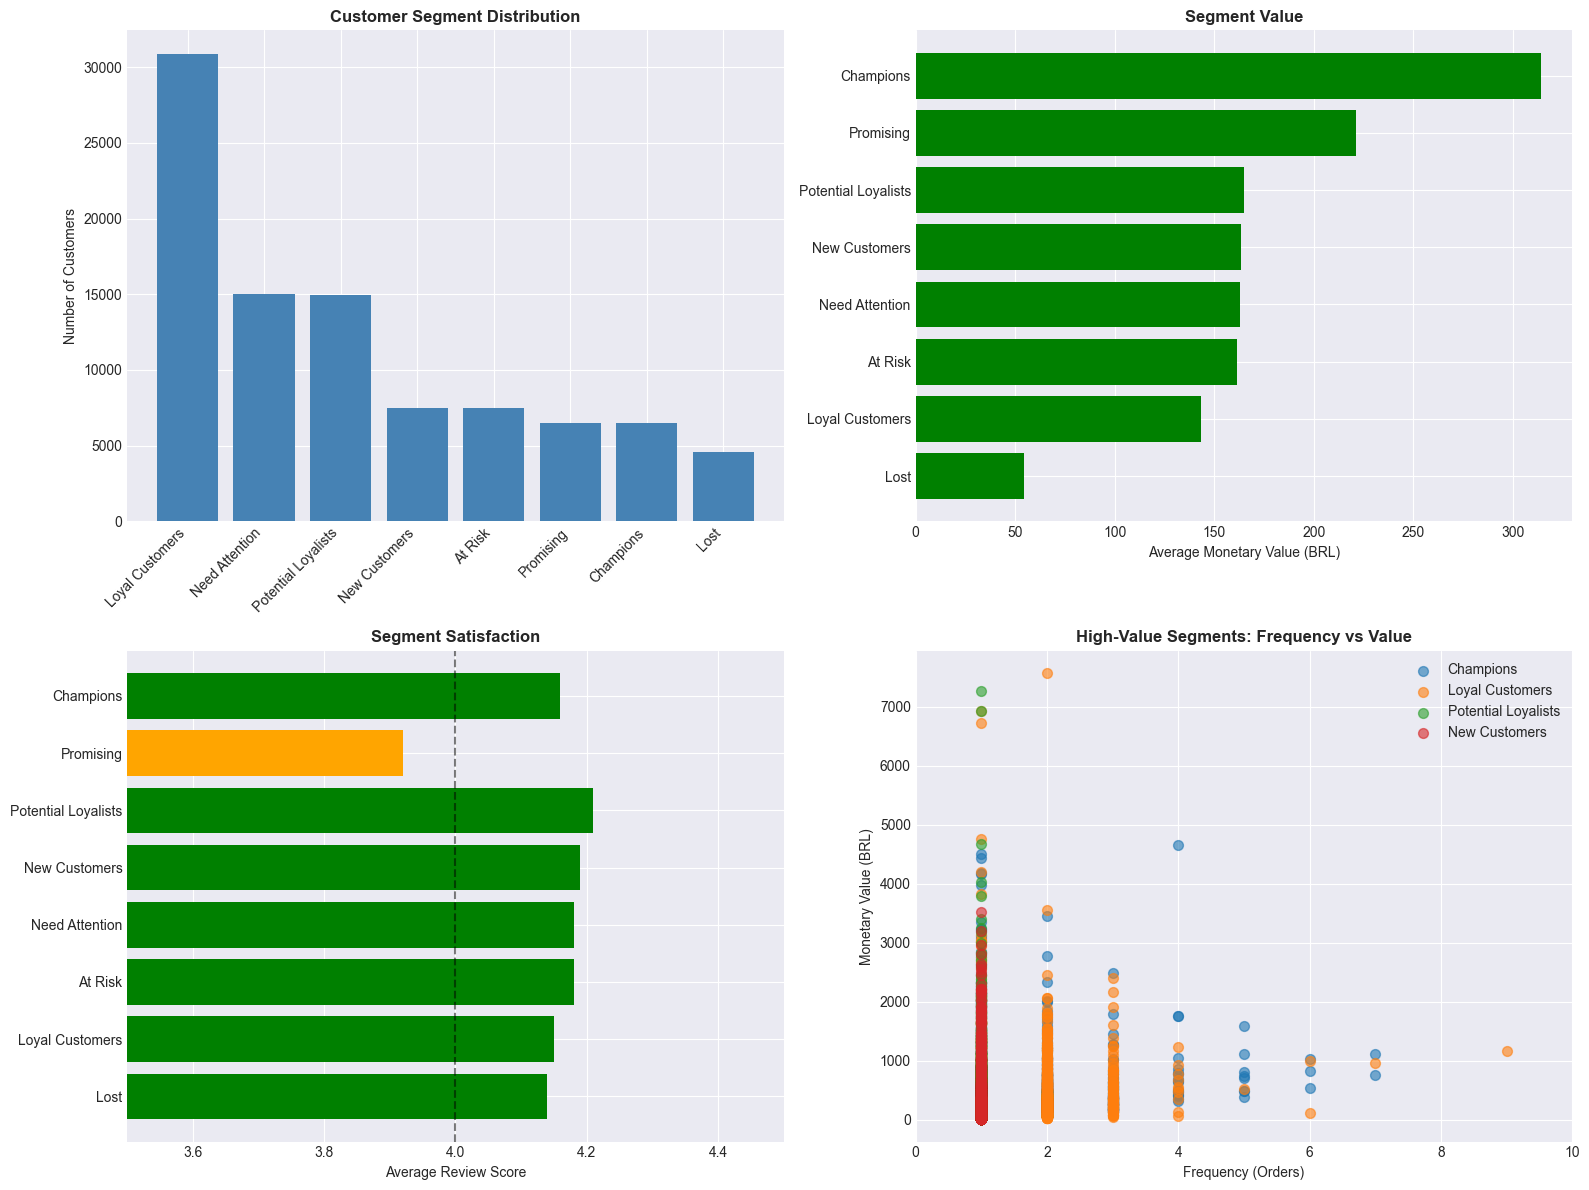

In [6]:
# Segment Analysis - Deep Dive

segment_analysis = rfm.groupby('segment').agg({
    'customer_unique_id': 'count',
    'recency_days': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'avg_review': 'mean',
    'avg_delay': 'mean'
}).round(2)

segment_analysis.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Avg_Review', 'Avg_Delay']
segment_analysis = segment_analysis.sort_values('Avg_Monetary', ascending=False)

print("\nSegment Characteristics:")
print(segment_analysis)

# Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Segment sizes
segment_counts = rfm['segment'].value_counts()
axes[0, 0].bar(range(len(segment_counts)), segment_counts.values, color='steelblue')
axes[0, 0].set_xticks(range(len(segment_counts)))
axes[0, 0].set_xticklabels(segment_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Customer Segment Distribution', fontweight='bold')

# Segment value
axes[0, 1].barh(range(len(segment_analysis)), segment_analysis['Avg_Monetary'], color='green')
axes[0, 1].set_yticks(range(len(segment_analysis)))
axes[0, 1].set_yticklabels(segment_analysis.index)
axes[0, 1].set_xlabel('Average Monetary Value (BRL)')
axes[0, 1].set_title('Segment Value', fontweight='bold')
axes[0, 1].invert_yaxis()

# Segment satisfaction
colors_sat = ['green' if x >= 4 else 'orange' if x >= 3.5 else 'red' for x in segment_analysis['Avg_Review']]
axes[1, 0].barh(range(len(segment_analysis)), segment_analysis['Avg_Review'], color=colors_sat)
axes[1, 0].set_yticks(range(len(segment_analysis)))
axes[1, 0].set_yticklabels(segment_analysis.index)
axes[1, 0].set_xlabel('Average Review Score')
axes[1, 0].set_title('Segment Satisfaction', fontweight='bold')
axes[1, 0].axvline(4.0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlim(3.5, 4.5)

# RFM scatter (top segments)
top_segments = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'New Customers']
for seg in top_segments:
    seg_data = rfm[rfm['segment'] == seg]
    axes[1, 1].scatter(seg_data['frequency'], seg_data['monetary'], 
                      alpha=0.6, s=50, label=seg)
axes[1, 1].set_xlabel('Frequency (Orders)')
axes[1, 1].set_ylabel('Monetary Value (BRL)')
axes[1, 1].set_title('High-Value Segments: Frequency vs Value', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 10)

plt.tight_layout()
plt.savefig('../reports/figures/customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()


### 2. Strategic Recommendations by Segment


In [8]:
segments_with_actions = {
    'Champions': {
        'size': len(rfm[rfm['segment'] == 'Champions']),
        'value': rfm[rfm['segment'] == 'Champions']['monetary'].sum(),
        'strategy': 'RETAIN & REWARD',
        'actions': [
            'VIP loyalty program with exclusive benefits',
            'Early access to new products/sales',
            'Premium customer service (dedicated support)',
            'Referral incentives (leverage advocacy)'
        ]
    },
    'Loyal Customers': {
        'size': len(rfm[rfm['segment'] == 'Loyal Customers']),
        'value': rfm[rfm['segment'] == 'Loyal Customers']['monetary'].sum(),
        'strategy': 'UPGRADE TO CHAMPIONS',
        'actions': [
            'Increase order frequency with targeted promotions',
            'Cross-sell complementary categories',
            'Subscription/autoship options for repeat purchases'
        ]
    },
    'Potential Loyalists': {
        'size': len(rfm[rfm['segment'] == 'Potential Loyalists']),
        'value': rfm[rfm['segment'] == 'Potential Loyalists']['monetary'].sum(),
        'strategy': 'CONVERT TO LOYAL',
        'actions': [
            'Onboarding email series (educate on platform)',
            'Second purchase incentive (discount on order #2)',
            'Personalized recommendations based on first purchase'
        ]
    },
    'New Customers': {
        'size': len(rfm[rfm['segment'] == 'New Customers']),
        'value': rfm[rfm['segment'] == 'New Customers']['monetary'].sum(),
        'strategy': 'ACTIVATE (CRITICAL!)',
        'actions': [
            'Welcome offer for 2nd purchase (within 30 days)',
            'Post-purchase follow-up (ensure satisfaction)',
            'Category exploration incentives',
            'THIS IS THE 97% - HIGHEST PRIORITY!'
        ]
    },
    'At Risk': {
        'size': len(rfm[rfm['segment'] == 'At Risk']),
        'value': rfm[rfm['segment'] == 'At Risk']['monetary'].sum(),
        'strategy': 'RE-ENGAGE',
        'actions': [
            'Win-back campaign ("We miss you" offer)',
            'Survey to understand churn reason',
            'Special comeback discount (limited time)'
        ]
    }
}

for segment, details in segments_with_actions.items():
    print(f"\n{segment.upper()}")
    print(f"  Size: {details['size']:,} customers ({details['size']/len(rfm)*100:.1f}%)")
    print(f"  Total Value: BRL {details['value']:,.0f}")
    print(f"  Strategy: {details['strategy']}")
    print(f"  Actions:")
    for action in details['actions']:
        print(f"    • {action}")


CHAMPIONS
  Size: 6,458 customers (6.9%)
  Total Value: BRL 2,028,847
  Strategy: RETAIN & REWARD
  Actions:
    • VIP loyalty program with exclusive benefits
    • Early access to new products/sales
    • Premium customer service (dedicated support)
    • Referral incentives (leverage advocacy)

LOYAL CUSTOMERS
  Size: 30,885 customers (33.1%)
  Total Value: BRL 4,426,522
  Strategy: UPGRADE TO CHAMPIONS
  Actions:
    • Increase order frequency with targeted promotions
    • Cross-sell complementary categories
    • Subscription/autoship options for repeat purchases

POTENTIAL LOYALISTS
  Size: 14,965 customers (16.0%)
  Total Value: BRL 2,467,918
  Strategy: CONVERT TO LOYAL
  Actions:
    • Onboarding email series (educate on platform)
    • Second purchase incentive (discount on order #2)
    • Personalized recommendations based on first purchase

NEW CUSTOMERS
  Size: 7,461 customers (8.0%)
  Total Value: BRL 1,219,824
  Strategy: ACTIVATE (CRITICAL!)
  Actions:
    • Welcome of

In [9]:
conn.close()
print("Db Connection Closed")

Db Connection Closed
